# Exploring Crowded Spiral Tip Kinematics
Tim Tyree<br>
12.2.2021

In [7]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
#set random seed
cp.random.seed(42)
np.random.seed(42)
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart


In [8]:
#reset matplotlib
import matplotlib as mpl
mpl.rcParams.update(matplotlib.rcParamsDefault)

# define module

In [62]:
def comp_kinematic_periods(input_fn,event_index_values,DT,
    DS=5/200, #cm per pixel
    tavg2=14, #ms
#     maxT=4,#seconds #max average period acceptable from particles
    **kwargs):
    """
    Example Usage:
meanT_values,lifetime_values,v_rms_values,maxT_values,minT_values=comp_kinematic_periods(input_fn,event_index_values)
    """
    #input: input_fn of unwrapped trajectories and event_index_values that were considered in the MSR plots
    #output: mean kinematic periods for particles
    fn = os.path.basename(input_fn)
    event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
    event_id_int

    #get a unique list of all particles involved in an annihilation event for this event_id_int
    pid_lst=[]
    for x in event_index_values:
        if int(x[0])==event_id_int:
            pid_lst.append(int(x[1]))
            pid_lst.append(int(x[2]))

    pid_values=np.unique(np.array(pid_lst))
    # assert len(pid_lst)==pid_values.shape[0] 

    #for each pid, compute the lifetime
    df=pd.read_csv(input_fn)

    lifetime_lst=[]
    for pid in pid_values:
        #compute time series data
        txy_values=df.loc[df['particle']==pid,['t','x','y']].values
        t_values=txy_values[:,0]-np.min(txy_values[:,0])
        #compute particle averaged values
        lifetime=(np.max(t_values)-np.min(t_values))*1e-3 #seconds
        #record
        lifetime_lst.append(lifetime)

    #DT=np.around(get_DT(df),7)

    navg2=int(tavg2/DT)
    if not (navg2%2==1): #odd navg2 is required by savgol_filter
        navg2+=1
        tavg2=np.around(navg2*DT,7)

    # #select only the particles that belong to pid_values
    boo=False
    for pid in pid_values:
        boo|=df['particle']==pid

    if boo is False:
        return None
    if not boo.any():
        return None
    
    #compute the xy velocities for each group
    savgol_kwargs=dict(window_length=navg2,polyorder=3,
        deriv=1,delta=1.0,axis=-1,mode='interp')

    #compute the smoothed derivative savgol_filter using scipy's cryptic cython code
    df['vx']=np.nan
    df['vy']=np.nan
    grouped=df[boo].groupby('particle')
    result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
    df.loc[boo,'vx']=DS*np.concatenate(result.values)/(DT*1e-3) #cm/s
    result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
    df.loc[boo,'vy']=DS*np.concatenate(result.values)/(DT*1e-3) #cm/s

    #compute the xy accelerations for each group
    savgol_kwargs=dict(window_length=navg2,polyorder=3,
        deriv=2,delta=1.0,axis=-1,mode='interp')

    #compute the smoothed derivative savgol_filter using scipy's cryptic cython code
    df['ax']=np.nan
    df['ay']=np.nan
    grouped=df[boo].groupby('particle')
    result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
    df.loc[boo,'ax']=DS*np.concatenate(result.values)/(DT*1e-3)**2 #cm/s^2
    result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
    df.loc[boo,'ay']=DS*np.concatenate(result.values)/(DT*1e-3)**2 #cm/s^2

    #compute instantaneous period
    df['T']=2*np.pi*(df['vx']**2+df['vy']**2)/np.abs(df['vx']*df['ay'] - df['vy']*df['ax'])
    df['sq_vel']=df['vx']**2+df['vy']**2
    
    T_values=df.loc[boo,'T'].values
    # T_values.shape,np.min(T_values),np.max(T_values)

    #compute the mean period and lifetime for each particle
    d=df[boo]
    grouped=d.groupby('particle')
    meanT_values=grouped['T'].mean()
    maxT_values=grouped['T'].max()
    minT_values=grouped['T'].min()
    v_rms_values=np.sqrt(grouped['sq_vel'].mean())
    lifetime_values=grouped['t'].max()-grouped['t'].min()
    lifetime_values*=1e-3#seconds
    return meanT_values.values,lifetime_values.values,v_rms_values.values,maxT_values.values,minT_values.values
#     #filter out the large outliers?
#     booT=meanT_values<maxT
#     return meanT_values[booT],lifetime_values[booT],v_rms_values[booT]

In [3]:
def comp_lifetimes(input_fn,event_index_values):
    fn = os.path.basename(input_fn)
    event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
    event_id_int

    #get a unique list of all particles involved in an annihilation event for this event_id_int
    pid_lst=[]
    for x in event_index_values:
        if int(x[0])==event_id_int:
            pid_lst.append(int(x[1]))
            pid_lst.append(int(x[2]))

    pid_values=np.unique(np.array(pid_lst))
    # assert len(pid_lst)==pid_values.shape[0] 

    #for each pid, compute v_rms and the lifetime
    df=pd.read_csv(input_fn)

    lifetime_lst=[]
    for pid in pid_values:
        #compute time series data
        txy_values=df.loc[df['particle']==pid,['t','x','y']].values
        t_values=txy_values[:,0]-np.min(txy_values[:,0])
        #compute particle averaged values
        lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
        #record
        lifetime_lst.append(lifetime)
    return lifetime_lst

# dev

In [9]:
tavg1=0
tavg2=14#todo 0
#one token trajectory file for the fenton karma model and the luo-rudy model
input_fn_lst=[
# c='C0'
# # # # #token FK at DT=0.4
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
# c='C1'
# #tokenLR at DT=0.5
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
]

In [10]:
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'

In [11]:
data_dir=data_dir_lr
df_annihilation=cudf.read_csv(data_dir_lr)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values

# #FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
#LR
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
len(input_fn_lst)

159

# TODO: compute v_rms using finite difference method? ...just make sure no erroneous jumps first...
- TODO: plot and make sure that all pbc jumps are properly removed...
- TODO: only consider particles that display no clear pbc jumps in the estimation for the average lifetimes 

In [12]:
#input: input_fn of unwrapped trajectories and event_index_values that were considered in the MSR plots
#output: df with smoothed velocity and acceleration computed
fn = os.path.basename(input_fn)
event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
event_id_int

#get a unique list of all particles involved in an annihilation event for this event_id_int
pid_lst=[]
for x in event_index_values:
    if int(x[0])==event_id_int:
        pid_lst.append(int(x[1]))
        pid_lst.append(int(x[2]))

pid_values=np.unique(np.array(pid_lst))
# assert len(pid_lst)==pid_values.shape[0] 

#for each pid, compute the lifetime
df=pd.read_csv(input_fn)

lifetime_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    #record
    lifetime_lst.append(lifetime)

DT=np.around(get_DT(df),7)

DS=5/200

tavg2=14 #ms
navg2=int(tavg2/DT)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)

# #select only the particles that belong to pid_values
boo=False
for pid in pid_values:
    boo|=df['particle']==pid


#compute the xy velocities for each group
savgol_kwargs=dict(window_length=navg2,polyorder=3,
    deriv=1,delta=1.0,axis=-1,mode='interp')

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
df['vx']=np.nan
df['vy']=np.nan
grouped=df[boo].groupby('particle')
result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vx']=DS*np.concatenate(result.values)/DT*1e-3 #cm/s
result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vy']=DS*np.concatenate(result.values)/DT*1e-3 #cm/s

#compute the xy accelerations for each group
savgol_kwargs=dict(window_length=navg2,polyorder=3,
    deriv=2,delta=1.0,axis=-1,mode='interp')

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
df['ax']=np.nan
df['ay']=np.nan
grouped=df[boo].groupby('particle')
result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'ax']=DS*np.concatenate(result.values)/(DT*1e-3)**2 #cm/s^2
result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'ay']=DS*np.concatenate(result.values)/(DT*1e-3)**2 #cm/s^2

In [13]:
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))

In [14]:
#TODO: wrap for loop <for pid in pid_values> using a dask bag.
# b = db.from_sequence(input_fn_list, npartitions=12).map(run_routine)
# start = time.time()
# retval = list(b)
# print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
# beep(3)

In [15]:
lifetime_lst=[]
v_rms_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))
    #record
    lifetime_lst.append(lifetime)
    v_rms_lst.append(v_rms)

no smoothing was used in computing these squared displacements, so the numerical noise is normal...


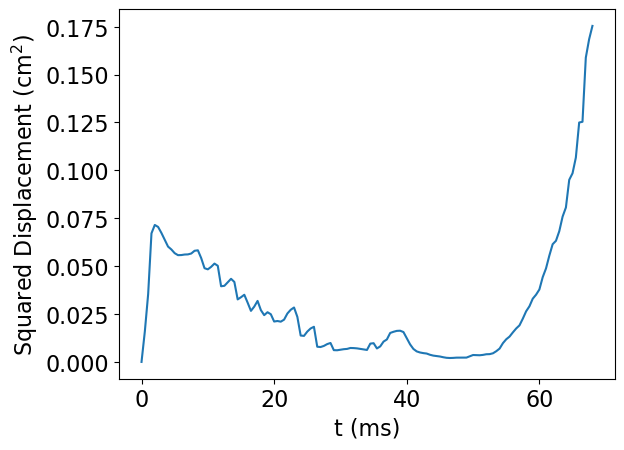

In [16]:
plt.plot(t_values,sd_values*DS**2)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Displacement (cm$^2$)',fontsize=16)
print(f"no smoothing was used in computing these squared displacements, so the numerical noise is normal...")
plt.show()

In [17]:
plt.plot(t_values,vsq_values)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Velocity (cm$^2$/s$^2$)',fontsize=16)

True

In [18]:
#print mean lifetime for these particles
mean_lifetime=np.mean(lifetime_lst)
lifetime_values=np.array(lifetime_lst)
num_obs=len(lifetime_lst)
Delta_mean_lifetime,p=bootstrap_95CI_Delta_mean(lifetime_values, num_samples=100)
print(f"the mean lifetime is {mean_lifetime:.4f} +/- {Delta_mean_lifetime:.4f} seconds (p_normal={p:.4f}) for these particles (N={num_obs}).")

the mean lifetime is 79.7885 +/- 15.8930 seconds (p_normal=0.1936) for these particles (N=52).


In [19]:
#print vrms for these particles
mean_v_rms=np.mean(v_rms_lst)
x_=np.array(v_rms_lst)
num_obs=len(v_rms_lst)
Delta_mean_v_rms,p=bootstrap_95CI_Delta_mean(x_, num_samples=100)
print(f"the mean v_rms is {mean_v_rms:.4f} +/- {Delta_mean_v_rms:.4f} cm/s (p_normal={p:.4f}) for these particles (N={num_obs}).")

the mean v_rms is 0.0000 +/- 0.0000 cm/s (p_normal=0.1601) for these particles (N=52).


In [ ]:
#TODO: fix v_rms
#TODO: aggregate over all annihilation events
#TODO: repeat for LR model

# TODO(later): measure period of oscillation 
- DONT: ~140ms and the parameters might be wrong - option A: for isolated spiral waves
- TODO: option B: for crowded spiral waves
        - option B.A:
        - HINT: try computing autocorrelation function of MSD, as for MSR, above...).
        - prerequisite, for each spiral pair involved in an annihilation, if it doesn't jump for x seconds, compute the MSD up until its first jump.
            - HINT: I think I have a function that does ^this somehwere...
            - TODO: check lib for this sd measurement function that works immediately.  If it doesn't work, just dev it here!
        - option B.B:
            - compare with some average measure of the period period,
            
$$
\hat{T}(t)=\frac{2\pi ||\vec{r}'(t)||^2}{||\vec{r}'(t)\times\vec{r}''(t)||}
$$

where the velocity and acceleration of the observed trajectory $\vec{r}(t)$ is computed using a Savitzky-Golay filtration.

In [1]:
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'

In [2]:
data_dir=data_dir_lr
df_annihilation=cudf.read_csv(data_dir)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values

# #FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
#LR
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
input_fn_lst=sorted(get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv'))
len(input_fn_lst)

NameError: name 'cudf' is not defined

In [65]:
df=pd.read_csv(input_fn)
DT=np.around(get_DT(df),7)
DT

0.5

In [67]:
meanT_values,lifetime_values,v_rms_values,maxT_values,minT_values=comp_kinematic_periods(input_fn,event_index_values,DT)

In [68]:
task_lst=[(fn,event_index_values.copy(),float(DT)) for fn in input_fn_lst]
len(task_lst)

159

In [69]:
np.mean(meanT_values)

0.8485978324004528

In [70]:
def routine(data):
    input_fn,event_index_values,DT=data
    meanT_values=comp_kinematic_periods(input_fn,event_index_values,DT)
    return meanT_values

In [71]:
# DONE: daskbag over ^that
b = db.from_sequence(task_lst, npartitions=os.cpu_count()).map(routine)
start = time.time()
retval = list(b)
print(f"run time for computed all mean kinematic periods: {time.time()-start:.2f} seconds.")
beep(3)

run time for computed all mean kinematic periods: 40.01 seconds.


0

meanT_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'


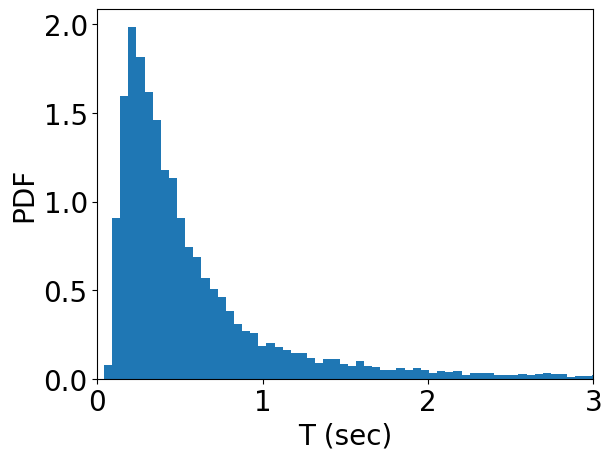

0.7344635639218905


In [84]:
#aggregate the data
meanT_lst=[]
v_rms_lst=[]
lifetime_lst=[]
maxT_lst=[]
minT_lst=[]
for rv in retval:
    if rv is not None:
        meanT,lifetime,v_rms,maxT,minT=rv
        meanT_lst.extend(meanT)
        v_rms_lst.extend(v_rms)
        lifetime_lst.extend(lifetime)
        maxT_lst.extend(maxT)
        minT_lst.extend(minT)
meanT_values=np.array(meanT_lst)
v_rms_values=np.array(v_rms_lst)
lifetime_values=np.array(lifetime_lst)
maxT_values=np.array(maxT_lst)
minT_values=np.array(minT_lst)

#DONE: save meanT_values as .npz
save_fn='luorudy_mean_kinematic_periods.npz'
# save_fn='fentonkarma_mean_kinematic_periods.npz'
save_folder=os.path.dirname(data_dir)
save_dir=os.path.join(save_folder,save_fn)
np.savez_compressed(save_dir,
                    meanT_values=meanT_values,
                    v_rms_values=v_rms_values,
                    lifetime_values=lifetime_values,
                    maxT_values=maxT_values,
                   minT_values=minT_values)
print(f"meanT_dir='{save_dir}'")

plt.hist(meanT_values[meanT_values<10],density=True,bins=200)
# plt.xscale('log')
# plt.yscale('log')
format_plot(ax=plt.gca(),xlabel='T (sec)',ylabel='PDF')
plt.xlim([0,3])
plt.show()
print(np.mean(meanT_values[meanT_values<10]))

In [85]:
data_dir=data_dir_fk
df_annihilation=cudf.read_csv(data_dir)
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values

#FK
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
# #LR
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
input_fn_lst=sorted(get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv'))
len(input_fn_lst)

324

np.mean(meanT_values)=1.7543785955025428 #resulted from test case
performihng 324 tasks...
run time for computed all mean kinematic periods: 164.64 seconds.
meanT_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'


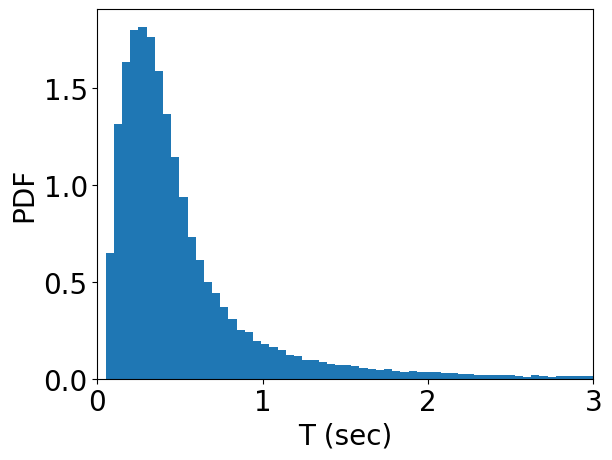

0.6085764706281694


In [87]:
df=pd.read_csv(input_fn)
DT=np.around(get_DT(df),7)
testing=True
if testing:
    meanT_values,lifetime_values,v_rms_values,maxT_values,minT_values=comp_kinematic_periods(input_fn,event_index_values,DT)
    print(f"np.mean(meanT_values)={np.mean(meanT_values)} #resulted from test case")
task_lst=[(fn,event_index_values.copy(),float(DT)) for fn in input_fn_lst]
print(f"performihng {len(task_lst)} tasks...")

def routine(data):
    input_fn,event_index_values,DT=data
    meanT_values=comp_kinematic_periods(input_fn,event_index_values,DT)
    return meanT_values

# DONE: daskbag over ^that
b = db.from_sequence(task_lst, npartitions=os.cpu_count()).map(routine)
start = time.time()
retval = list(b)
print(f"run time for computed all mean kinematic periods: {time.time()-start:.2f} seconds.")
beep(3)
#aggregate the data
meanT_lst=[]
v_rms_lst=[]
lifetime_lst=[]
maxT_lst=[]
minT_lst=[]
for rv in retval:
    if rv is not None:
        meanT,lifetime,v_rms,maxT,minT=rv
        meanT_lst.extend(meanT)
        v_rms_lst.extend(v_rms)
        lifetime_lst.extend(lifetime)
        maxT_lst.extend(maxT)
        minT_lst.extend(minT)
meanT_values=np.array(meanT_lst)
v_rms_values=np.array(v_rms_lst)
lifetime_values=np.array(lifetime_lst)
maxT_values=np.array(maxT_lst)
minT_values=np.array(minT_lst)

#DONE: save meanT_values as .npz
# save_fn='luorudy_mean_kinematic_periods.npz'
save_fn='fentonkarma_mean_kinematic_periods.npz'
save_folder=os.path.dirname(data_dir)
save_dir=os.path.join(save_folder,save_fn)
np.savez_compressed(save_dir,
                    meanT_values=meanT_values,
                    v_rms_values=v_rms_values,
                    lifetime_values=lifetime_values,
                    maxT_values=maxT_values,
                   minT_values=minT_values)
print(f"meanT_dir='{save_dir}'")

plt.hist(meanT_values[meanT_values<10],density=True,bins=200)
# plt.xscale('log')
# plt.yscale('log')
format_plot(ax=plt.gca(),xlabel='T (sec)',ylabel='PDF')
plt.xlim([0,3])
plt.show()
print(np.mean(meanT_values[meanT_values<10]))

In [171]:
#DONE: wrap ^this into a function
#DONE: compute meanT values for all particles in input_fn_lst
#DONE: make a histogram showing the distribution of particle periods
#TODO: record mean and Delta_mean for LR model
#TODO: repeat for FK model

# equation for how mean kinematic period was calculated
The mean kinematic period of the $i^{th}$ particle was computed according to
$$
T_i=\frac{1}{\Gamma}\int_0^\Gamma dt \frac{2\pi ||\vec{x}_i'(t)||^2}{||\vec{x}_i'(t)\times\vec{x}_i''(t)||}
$$

We observed 

$$T_i\sim \text{Poisson}[\mathbb{E}_i[T_i]]$$.

# TODO: visualize those histograms for both full models for each measure

In [90]:
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
data_lr=np.load(meanT_dir_lr)
data_fk=np.load(meanT_dir_fk)

In [91]:
use_loglog=False

In [ ]:
meanT_values_lr=data_lr['meanT_values']
meanT_values_fk=data_lr['meanT_values']

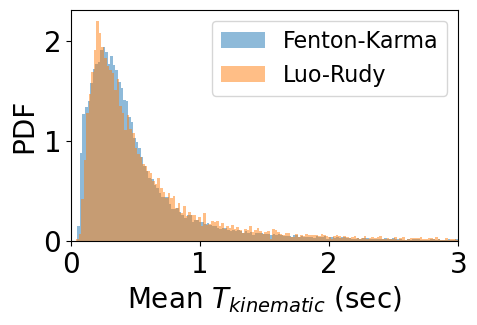

********************************************************
* Mean Values For Crowded Dynamics Spiral Defect Chaos *
********************************************************
Fenton-Karma: meanT_values
the mean value: is 0.5056 +/- 0.0044 seconds (p_normal=0.8576)
for this average (N=42025).
Luo-Rudy:     meanT_values
the mean value: is 0.5600 +/- 0.0102 seconds (p_normal=0.6262)
for this average (N=9861).


In [129]:
xlim=[0,3]
bins=150
x_col='meanT_values'
xlabel=r'Mean $T_{kinematic}$ (sec)'
printing=True
plotting=True
#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
x_values_fk=x_fk[x_fk<xlim[1]]
x_values_lr=x_lr[x_lr<xlim[1]]
if plotting:
    #plot histograms of data
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(x_values_fk,density=True,bins=bins,color='C0',alpha=0.5,label='Fenton-Karma')
    plt.hist(x_values_lr,density=True,bins=bins,color='C1',alpha=0.5,label='Luo-Rudy')
    if use_loglog:
        plt.xscale('log')
        plt.yscale('log')
    format_plot(ax=plt.gca(),xlabel=xlabel,ylabel='PDF')
    plt.xlim(xlim)
    plt.legend(loc='upper right',fontsize=16)
    plt.show()
if printing:
    print(f"********************************************************")
    print(f"* Mean Values For Crowded Dynamics Spiral Defect Chaos *")
    print(f"********************************************************")
    print(f"""Fenton-Karma: {x_col}""")
    mean_fk=np.mean(x_values_fk)
    Delta_mean_fk,p_fk=bootstrap_95CI_Delta_mean(x_values_fk, num_samples=100)
    num_obs_fk=x_values_fk.shape[0]
    print(f"the mean value: is {mean_fk:.4f} +/- {Delta_mean_fk:.4f} seconds (p_normal={p_fk:.4f})\nfor this average (N={num_obs_fk}).")
    print(f"""Luo-Rudy:     {x_col}""")
    mean_lr=np.mean(x_values_lr)
    Delta_mean_lr,p_lr=bootstrap_95CI_Delta_mean(x_values_lr, num_samples=100)
    num_obs_lr=x_values_lr.shape[0]
    print(f"the mean value: is {mean_lr:.4f} +/- {Delta_mean_lr:.4f} seconds (p_normal={p_lr:.4f})\nfor this average (N={num_obs_lr}).")

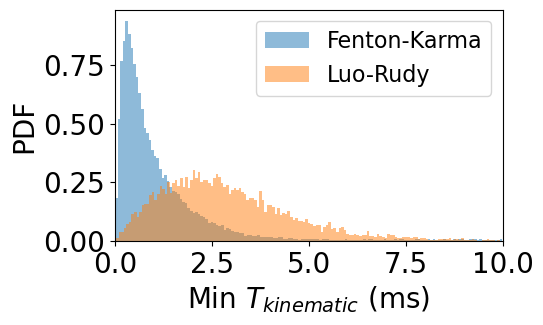

********************************************************
* Mean Values For Crowded Dynamics Spiral Defect Chaos *
********************************************************
Fenton-Karma: minT_values
the mean value: is 1.1639 +/- 0.0137 seconds (p_normal=0.7087)
for this average (N=39839).
Luo-Rudy:     minT_values
the mean value: is 2.8929 +/- 0.0342 seconds (p_normal=0.7399)
for this average (N=10095).


In [132]:
xlim=[0,.01]
bins=150
x_col='minT_values'
xlabel=r'Min $T_{kinematic}$ (ms)'
printing=True
plotting=True
#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
x_values_fk=x_fk[x_fk<xlim[1]]*1e3#ms
x_values_lr=x_lr[x_lr<xlim[1]]*1e3#ms
if plotting:
    #plot histograms of data
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(x_values_fk,density=True,bins=bins,color='C0',alpha=0.5,label='Fenton-Karma')
    plt.hist(x_values_lr,density=True,bins=bins,color='C1',alpha=0.5,label='Luo-Rudy')
    if use_loglog:
        plt.xscale('log')
        plt.yscale('log')
    format_plot(ax=plt.gca(),xlabel=xlabel,ylabel='PDF')
    plt.xlim((xlim[0]*1e3,xlim[1]*1e3))
    plt.legend(loc='upper right',fontsize=16)
#     plt.xticks(rotation=45)
    plt.show()
if printing:
    print(f"********************************************************")
    print(f"* Mean Values For Crowded Dynamics Spiral Defect Chaos *")
    print(f"********************************************************")
    print(f"""Fenton-Karma: {x_col}""")
    mean_fk=np.mean(x_values_fk)
    Delta_mean_fk,p_fk=bootstrap_95CI_Delta_mean(x_values_fk, num_samples=100)
    num_obs_fk=x_values_fk.shape[0]
    print(f"the mean value: is {mean_fk:.4f} +/- {Delta_mean_fk:.4f} seconds (p_normal={p_fk:.4f})\nfor this average (N={num_obs_fk}).")
    print(f"""Luo-Rudy:     {x_col}""")
    mean_lr=np.mean(x_values_lr)
    Delta_mean_lr,p_lr=bootstrap_95CI_Delta_mean(x_values_lr, num_samples=100)
    num_obs_lr=x_values_lr.shape[0]
    print(f"the mean value: is {mean_lr:.4f} +/- {Delta_mean_lr:.4f} seconds (p_normal={p_lr:.4f})\nfor this average (N={num_obs_lr}).")

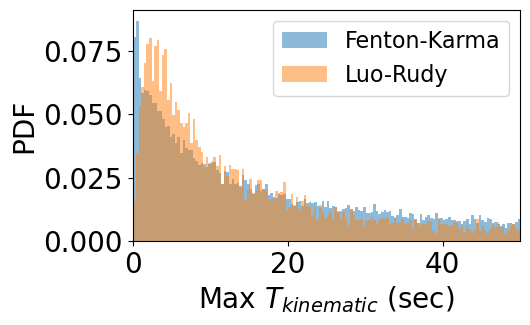

********************************************************
* Mean Values For Crowded Dynamics Spiral Defect Chaos *
********************************************************
Fenton-Karma: maxT_values
the mean value: is 15.7186 +/- 0.1698 seconds (p_normal=0.3004)
for this average (N=25920).
Luo-Rudy:     maxT_values
the mean value: is 13.6446 +/- 0.2672 seconds (p_normal=0.3351)
for this average (N=8199).


In [124]:
xlim=[0,50]
bins=150
x_col='maxT_values'
xlabel=r'Max $T_{kinematic}$ (sec)'
printing=True
plotting=True
#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
x_values_fk=x_fk[x_fk<xlim[1]]
x_values_lr=x_lr[x_lr<xlim[1]]
if plotting:
    #plot histograms of data
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(x_values_fk,density=True,bins=bins,color='C0',alpha=0.5,label='Fenton-Karma')
    plt.hist(x_values_lr,density=True,bins=bins,color='C1',alpha=0.5,label='Luo-Rudy')
    if use_loglog:
        plt.xscale('log')
        plt.yscale('log')
    format_plot(ax=plt.gca(),xlabel=xlabel,ylabel='PDF')
    plt.xlim(xlim)
    plt.legend(loc='upper right',fontsize=16)
    plt.show()
if printing:
    print(f"********************************************************")
    print(f"* Mean Values For Crowded Dynamics Spiral Defect Chaos *")
    print(f"********************************************************")
    print(f"""Fenton-Karma: {x_col}""")
    mean_fk=np.mean(x_values_fk)
    Delta_mean_fk,p_fk=bootstrap_95CI_Delta_mean(x_values_fk, num_samples=100)
    num_obs_fk=x_values_fk.shape[0]
    print(f"the mean value: is {mean_fk:.4f} +/- {Delta_mean_fk:.4f} seconds (p_normal={p_fk:.4f})\nfor this average (N={num_obs_fk}).")
    print(f"""Luo-Rudy:     {x_col}""")
    mean_lr=np.mean(x_values_lr)
    Delta_mean_lr,p_lr=bootstrap_95CI_Delta_mean(x_values_lr, num_samples=100)
    num_obs_lr=x_values_lr.shape[0]
    print(f"the mean value: is {mean_lr:.4f} +/- {Delta_mean_lr:.4f} seconds (p_normal={p_lr:.4f})\nfor this average (N={num_obs_lr}).")

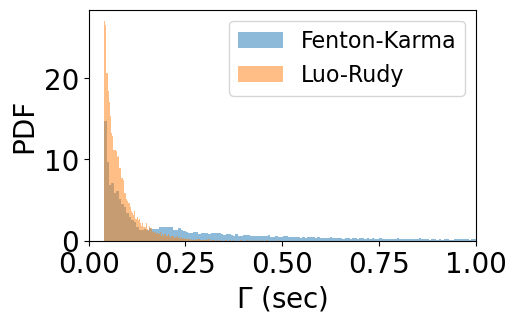

********************************************************
* Mean Values For Crowded Dynamics Spiral Defect Chaos *
********************************************************
Fenton-Karma: lifetime_values
the mean value: is 0.2345 +/- 0.0023 seconds (p_normal=0.9383)
for this average (N=40643).
Luo-Rudy:     lifetime_values
the mean value: is 0.0827 +/- 0.0008 seconds (p_normal=0.3351)
for this average (N=10362).


In [128]:
xlim=[0,1]
bins=150
x_col='lifetime_values'
xlabel=r'$\Gamma$ (sec)'
printing=True
plotting=True
#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
x_values_fk=x_fk[x_fk<xlim[1]]
x_values_lr=x_lr[x_lr<xlim[1]]
if plotting:
    #plot histograms of data
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(x_values_fk,density=True,bins=bins,color='C0',alpha=0.5,label='Fenton-Karma')
    plt.hist(x_values_lr,density=True,bins=bins,color='C1',alpha=0.5,label='Luo-Rudy')
    if use_loglog:
        plt.xscale('log')
        plt.yscale('log')
    format_plot(ax=plt.gca(),xlabel=xlabel,ylabel='PDF')
    plt.xlim(xlim)
    plt.legend(loc='upper right',fontsize=16)
    plt.show()
if printing:
    print(f"********************************************************")
    print(f"* Mean Values For Crowded Dynamics Spiral Defect Chaos *")
    print(f"********************************************************")
    print(f"""Fenton-Karma: {x_col}""")
    mean_fk=np.mean(x_values_fk)
    Delta_mean_fk,p_fk=bootstrap_95CI_Delta_mean(x_values_fk, num_samples=100)
    num_obs_fk=x_values_fk.shape[0]
    print(f"the mean value: is {mean_fk:.4f} +/- {Delta_mean_fk:.4f} seconds (p_normal={p_fk:.4f})\nfor this average (N={num_obs_fk}).")
    print(f"""Luo-Rudy:     {x_col}""")
    mean_lr=np.mean(x_values_lr)
    Delta_mean_lr,p_lr=bootstrap_95CI_Delta_mean(x_values_lr, num_samples=50)
    num_obs_lr=x_values_lr.shape[0]
    print(f"the mean value: is {mean_lr:.4f} +/- {Delta_mean_lr:.4f} seconds (p_normal={p_lr:.4f})\nfor this average (N={num_obs_lr}).")

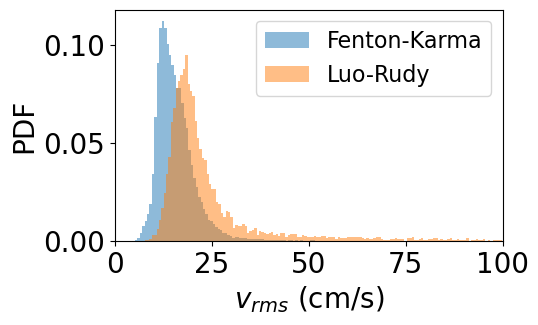

********************************************************
* Mean Values For Crowded Dynamics Spiral Defect Chaos *
********************************************************
Fenton-Karma: v_rms_values
the mean value: is 15.7231 +/- 0.0487 seconds (p_normal=0.2537)
for this average (N=43294).
Luo-Rudy:     v_rms_values
the mean value: is 23.6076 +/- 0.2354 seconds (p_normal=0.5734)
for this average (N=10221).


In [137]:
xlim=[0,100]
bins=150
x_col='v_rms_values'
xlabel=r'$v_{rms}$ (cm/s)'
printing=True
plotting=True
#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
x_values_fk=x_fk[x_fk<xlim[1]]
x_values_lr=x_lr[x_lr<xlim[1]]
if plotting:
    #plot histograms of data
    fig,ax=plt.subplots(figsize=(5,3))
    plt.hist(x_values_fk,density=True,bins=bins,color='C0',alpha=0.5,label='Fenton-Karma')
    plt.hist(x_values_lr,density=True,bins=bins,color='C1',alpha=0.5,label='Luo-Rudy')
    if use_loglog:
        plt.xscale('log')
        plt.yscale('log')
    format_plot(ax=plt.gca(),xlabel=xlabel,ylabel='PDF')
    plt.xlim(xlim)
    plt.legend(loc='upper right',fontsize=16)
    plt.show()
if printing:
    print(f"********************************************************")
    print(f"* Mean Values For Crowded Dynamics Spiral Defect Chaos *")
    print(f"********************************************************")
    print(f"""Fenton-Karma: {x_col}""")
    mean_fk=np.mean(x_values_fk)
    Delta_mean_fk,p_fk=bootstrap_95CI_Delta_mean(x_values_fk, num_samples=100)
    num_obs_fk=x_values_fk.shape[0]
    print(f"the mean value: is {mean_fk:.4f} +/- {Delta_mean_fk:.4f} seconds (p_normal={p_fk:.4f})\nfor this average (N={num_obs_fk}).")
    print(f"""Luo-Rudy:     {x_col}""")
    mean_lr=np.mean(x_values_lr)
    Delta_mean_lr,p_lr=bootstrap_95CI_Delta_mean(x_values_lr, num_samples=100)
    num_obs_lr=x_values_lr.shape[0]
    print(f"the mean value: is {mean_lr:.4f} +/- {Delta_mean_lr:.4f} seconds (p_normal={p_lr:.4f})\nfor this average (N={num_obs_lr}).")

# scatter plot of minimum kinematic period versus lifetime for both of the full models

In [182]:
xlim=[0,100]
bins=150
xlim=[0,5]
x_col='lifetime_values'
xlabel=r'$\Gamma$ (sec)'
ylim=[0,1]
y_col='minT_values'
ylabel=r'Min $T_{kinematic}$ (ms)'
printing=True
plotting=True

#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
y_lr=data_lr[y_col]
y_fk=data_fk[y_col]
boo_fk=(x_fk<xlim[1])&(y_fk<ylim[1])
boo_lr=(x_lr<xlim[1])&(y_lr<ylim[1])
x_values_fk=x_fk[boo_fk]
x_values_lr=x_lr[boo_lr]
y_values_fk=y_fk[boo_fk]
y_values_lr=y_lr[boo_lr]

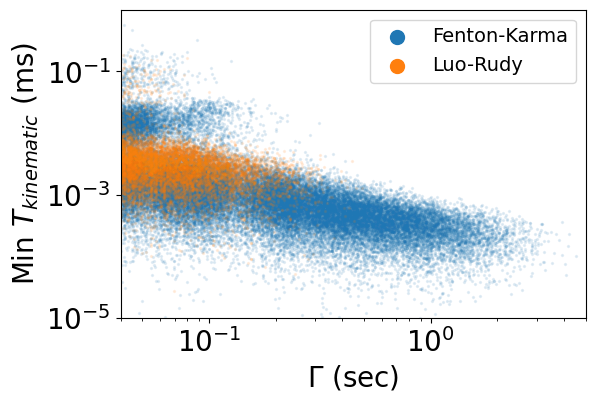

In [194]:
#plot scatter plots of data
xlim=[4e-2,xlim[1]]
ylim=[1e-5,ylim[1]]
fig,ax=plt.subplots(figsize=(6,4))
plt.scatter(x_values_fk,y_values_fk,color='C0',alpha=0.1,label='Fenton-Karma',s=2)
plt.scatter(x_values_lr,y_values_lr,color='C1',alpha=0.1,label='Luo-Rudy',s=2)
format_plot(ax=plt.gca(),xlabel=xlabel,ylabel=ylabel)
plt.xlim(xlim)
plt.ylim(ylim)
leg=plt.legend(loc='upper right',fontsize=14)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)#.set_color('black')
leg.legendHandles[0]._sizes = [100]
leg.legendHandles[1].set_alpha(1)#.set_color('black')
leg.legendHandles[1]._sizes = [100]
plt.xscale('log')
plt.yscale('log')
plt.show()

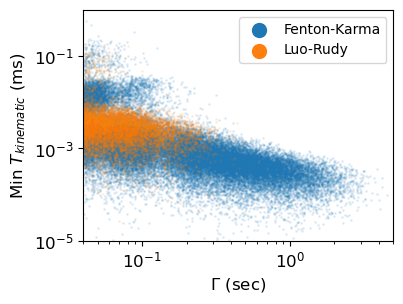

In [196]:
#plot scatter plots of data
xlim=[4e-2,xlim[1]]
ylim=[1e-5,ylim[1]]
fig,ax=plt.subplots(figsize=(4,3))
plt.scatter(x_values_fk,y_values_fk,color='C0',alpha=0.1,label='Fenton-Karma',s=1)
plt.scatter(x_values_lr,y_values_lr,color='C1',alpha=0.1,label='Luo-Rudy',s=1)
format_plot(ax=plt.gca(),xlabel=xlabel,ylabel=ylabel,fontsize=12)
plt.xlim(xlim)
plt.ylim(ylim)
leg=plt.legend(loc='upper right',fontsize=10)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)#.set_color('black')
leg.legendHandles[0]._sizes = [100]
leg.legendHandles[1].set_alpha(1)#.set_color('black')
leg.legendHandles[1]._sizes = [100]
plt.xscale('log')
plt.yscale('log')
plt.show()

# scatter plot of minimum kinematic period versus v_rms for both of the full models

In [218]:
xlim=[0,500]
x_col='v_rms_values'
xlabel=r'$v_{rms}$ (cm/s)'
ylim=[0,5]
y_col='minT_values'
ylabel=r'Min $T_{kinematic}$ (ms)'
printing=True
plotting=True

#extract and filter data
x_lr=data_lr[x_col]
x_fk=data_fk[x_col]
y_lr=data_lr[y_col]
y_fk=data_fk[y_col]
boo_fk=(x_fk<xlim[1])&(y_fk<ylim[1])
boo_lr=(x_lr<xlim[1])&(y_lr<ylim[1])
x_values_fk=x_fk[boo_fk]
x_values_lr=x_lr[boo_lr]
y_values_fk=y_fk[boo_fk]
y_values_lr=y_lr[boo_lr]

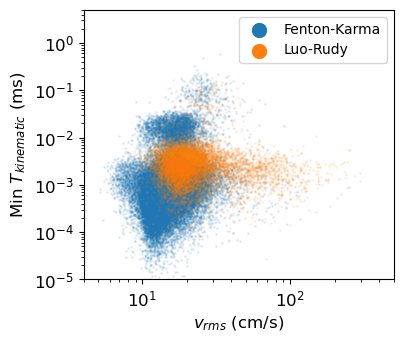

In [219]:
#plot scatter plots of data
xlim=[4e-0,xlim[1]]
ylim=[1e-5,ylim[1]]
fig,ax=plt.subplots(figsize=(4,3.5))
plt.scatter(x_values_fk,y_values_fk,color='C0',alpha=0.1,label='Fenton-Karma',s=1)
plt.scatter(x_values_lr,y_values_lr,color='C1',alpha=0.1,label='Luo-Rudy',s=1)
format_plot(ax=plt.gca(),xlabel=xlabel,ylabel=ylabel,fontsize=12)
plt.xlim(xlim)
plt.ylim(ylim)
leg=plt.legend(loc='upper right',fontsize=10)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)#.set_color('black')
leg.legendHandles[0]._sizes = [100]
leg.legendHandles[1].set_alpha(1)#.set_color('black')
leg.legendHandles[1]._sizes = [100]
plt.xscale('log')
plt.yscale('log')
plt.show()